In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : 1MUXqVCD 

  Total counts                    : 361088 
  Total background counts         : 360331.31
  Total excess counts             : 756.96

  Predicted counts                : 361088.27
  Predicted background counts     : 360331.34
  Predicted excess counts         : 756.93

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -752490.77

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal mo

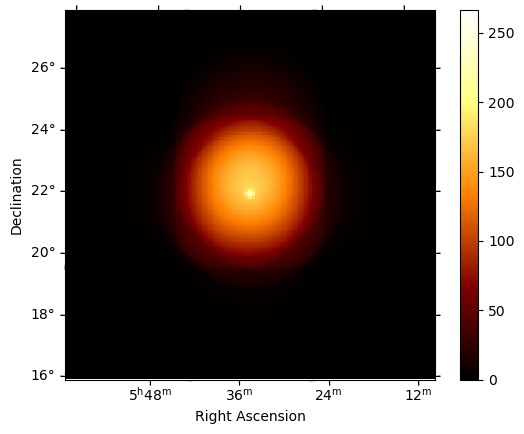

In [3]:
dataset_asimov = MapDataset.read("c:/users/yt02izug/downloads/dataset_asimov/dataset_asimov.fits")
# Create the spatial model 
model_spatial = GaussianSpatialModel(
    lon_0="83.631 deg",
    lat_0="22.018 deg",
    sigma="0.02 deg",
    )

# Create the spectral model 
model_spectrum  = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",
    lambda_="0.1 TeV-1"
)

# combine the spectral and the spatial model
source_model = SkyModel(spatial_model = model_spatial ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

# Create the model for the Background
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)

# set the models in the dataset
dataset_asimov.models = models
# set counts
dataset_asimov.counts = dataset_asimov.npred()
    
dataset_asimov.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_asimov.geoms["geom"].width[1] / dataset_asimov.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_asimov)

## Varying the Exposure

In [4]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value

# energy independent method: pm 10% for reconstructed energy
shift_neg = -0.1 #-0.085
shift_pos = 0.1 #0.085
shift_cor = 0.0

tilt_neg = -0.015 # 1e-25 for computational purposes -> covmatrix "1/0"
tilt_pos = 0.015
tilt_cor = 0.0

In [5]:
def sum_e(x):
    return x.sum(axis=2).sum(axis=1)

In [8]:
sys_d_cor = sys_dataset(dataset_asimov, shift_cor, tilt_cor, False)
dataset_cor = sys_d_cor.create_dataset()

sys_d_neg = sys_dataset(dataset_asimov, shift_neg, tilt_neg, False)
dataset_neg = sys_d_neg.create_dataset()

sys_d_pos = sys_dataset(dataset_asimov, shift_pos, tilt_pos, False)
dataset_pos = sys_d_pos.create_dataset()

#print(dataset_cor)

In [9]:
exposure_pos = dataset_pos.exposure
exposure_neg = dataset_neg.exposure

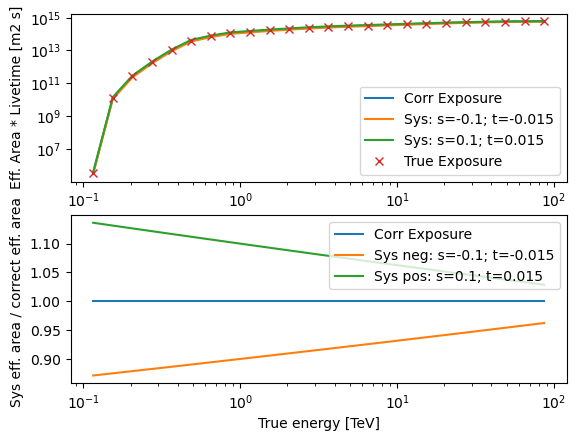

In [10]:
fig,ax = plt.subplots(2,1)

exposure_standard = dataset_asimov.exposure.data.sum(axis=2).sum(axis=1)
exposure_e = dataset_cor.exposure.data.sum(axis=2).sum(axis=1)

ax[0].plot(true_energy, exposure_e, label = "Corr Exposure")
ax[0].plot(true_energy, sum_e(exposure_neg.data), 
           label = f'Sys: s={shift_neg:.2}; t={tilt_neg:.2}')
ax[0].plot(true_energy, sum_e(exposure_pos.data), 
           label = f'Sys: s={shift_pos:.2}; t={tilt_pos:.2}')
ax[0].plot(true_energy, exposure_standard, 'x', label = "True Exposure")

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel("True energy [TeV]")
ax[0].set_ylabel(f"Eff. Area * Livetime [{dataset_asimov.exposure.unit}]")
ax[0].legend()

ax[1].plot(true_energy, exposure_e/exposure_standard, label = "Corr Exposure")
ax[1].plot(true_energy, sum_e(exposure_neg.data)/exposure_e,
           label = f'Sys neg: s={shift_neg:.2}; t={tilt_neg:.2}')
ax[1].plot(true_energy, sum_e(exposure_pos.data)/ exposure_e, 
           label = f'Sys pos: s={shift_pos:.2}; t={tilt_pos:.2}')

#ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel("True energy [TeV]")
ax[1].set_ylabel(f"Sys eff. area / correct eff. area ")
ax[1].legend()

fig.savefig("plots/1b_exposure_example.pdf")

C:\Users\yt02izug\AppData\Local\Temp\ipykernel_4152\2364907604.py:23: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(true_energy, npred/npred, label = "Model ")
C:\Users\yt02izug\AppData\Local\Temp\ipykernel_4152\2364907604.py:24: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(true_energy, npred_neg/npred,
C:\Users\yt02izug\AppData\Local\Temp\ipykernel_4152\2364907604.py:26: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(true_energy, npred_pos/npred,


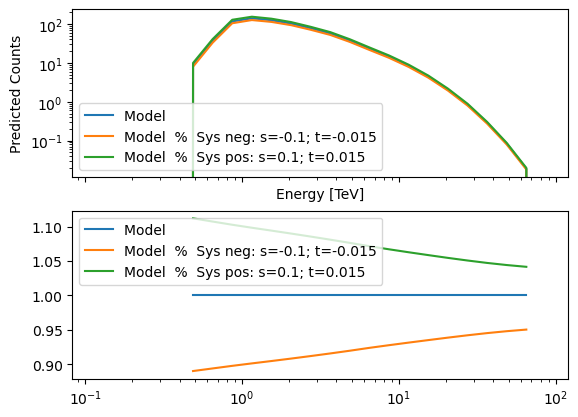

In [11]:
fig,ax = plt.subplots(2,1, sharex = True)

energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV

npred =     dataset_cor.npred_signal().data.sum(axis = 2).sum(axis= 1) #or (dataset_cor.counts - dataset_cor.background)
npred_neg = dataset_neg.npred_signal().data.sum(axis = 2).sum(axis= 1)
npred_pos = dataset_pos.npred_signal().data.sum(axis = 2).sum(axis= 1)


ax[0].plot(true_energy, npred, label = "Model ")
ax[0].plot(true_energy, npred_neg, 
         label =f"Model  %  Sys neg: s={shift_neg:.2}; t={tilt_neg:.2}")
ax[0].plot(true_energy, npred_pos,  
         label =f"Model  %  Sys pos: s={shift_pos:.2}; t={tilt_pos:.2}")

         
ax[0].loglog()
ax[0].legend()
ax[0].set_xlabel("Energy [TeV]")
ax[0].set_ylabel("Predicted Counts")


ax[1].plot(true_energy, npred/npred, label = "Model ")
ax[1].plot(true_energy, npred_neg/npred, 
         label =f"Model  %  Sys neg: s={shift_neg:.2}; t={tilt_neg:.2}")
ax[1].plot(true_energy, npred_pos/npred,  
         label =f"Model  %  Sys pos: s={shift_pos:.2}; t={tilt_pos:.2}")

ax[1].legend()
ax[1].set_xscale('log')
fig = plt.gcf()
fig.savefig("plots/1b_counts.pdf")

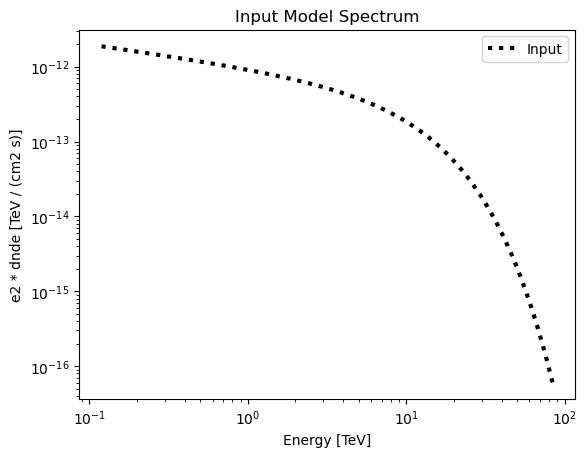

In [12]:
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV
#dataset_cor.models['Source'].spectral_model.plot(energy_bounds, label = "Spectrum")
#dataset_neg.models['Source'].spectral_model.plot(energy_bounds, label = "")
#dataset_pos.models['Source'].spectral_model.plot(energy_bounds, label = "")
dataset_asimov.models['Source'].spectral_model.plot(energy_bounds, energy_power = 2,
                                label = "Input", color = 'black', linewidth = 3, linestyle ='dotted')
plt.title("Input Model Spectrum")
plt.legend()

In [13]:
%%time
fit_cor = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_cor.backend = "minuit"
fit_cor.optimize_opts = minuit_opts
result_cor = fit_cor.run([dataset_cor])

fit_neg = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_neg.backend = "minuit"
fit_neg.optimize_opts = minuit_opts
result_neg = fit_neg.run([dataset_neg])

fit_pos = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_pos.backend = "minuit"
fit_pos.optimize_opts = minuit_opts
result_pos = fit_pos.run([dataset_pos])
print(result_pos)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : False
	message    : Optimization terminated successfully.
	nfev       : 774
	total stat : -752490.77

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

CPU times: total: 23.1 s
Wall time: 23.1 s


In [14]:
datasets_short = [dataset_neg, dataset_cor, dataset_pos]
print("Best Fit amplitude")
amplitudes = []
m = dataset_asimov.models['Source']
value = m.parameters['amplitude'].value 
error = m.parameters['amplitude'].error
amplitudes.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models['Source']
    value = m.parameters['amplitude'].value 
    error = m.parameters['amplitude'].error
    amplitudes.append((value, error))
    print(f'{value} pm {error}')
print()
print("Best Fit Index")
indices = []
m = dataset_asimov.models['Source']
value = m.parameters['index'].value 
error = m.parameters['index'].error
indices.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models['Source']
    value = m.parameters['index'].value 
    error = m.parameters['index'].error
    indices.append((value, error))
    print(f'{value} pm {error}')
print()

print("Best Fit bkg Norm")
norms = []
value = dataset_asimov.background_model.parameters['norm'].value 
error = dataset_asimov.background_model.parameters['norm'].error
norms.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.background_model.parameters['norm'].value 
    error = d.background_model.parameters['norm'].error
    print(f'{value} pm {error}')
    norms.append((value, error))
print()   
    
print("Best Fit Lambda")
lambdas = []
value = dataset_asimov.models.parameters['lambda_'].value 
error = dataset_asimov.models.parameters['lambda_'].error
lambdas.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.models.parameters['lambda_'].value 
    error = d.models.parameters['lambda_'].error
    print(f'{value} pm {error}')
    lambdas.append((value, error))
    
    
with open('data/1b_norms.yaml', 'w') as file:
    documents = yaml.dump(norms, file)
with open('data/1b_amplitudes.yaml', 'w') as file:
    documents = yaml.dump(amplitudes, file)
with open('data/1b_indices.yaml', 'w') as file:
    documents = yaml.dump(indices, file)
with open('data/1b_lambdas.yaml', 'w') as file:
    documents = yaml.dump(lambdas, file)
    
dataset_neg.models.write("data/1b_model_neg.yml", overwrite= True)
dataset_pos.models.write("data/1b_model_pos.yml", overwrite= True)
dataset_cor.models.write("data/1b_model_cor.yml", overwrite= True)

Best Fit amplitude
====
Input
1e-12 pm 0
====
1.1110642142356944e-12 pm 1.3639732801999805e-13
1.0000000003670398e-12 pm 1.2418610311728087e-13
9.098008286121431e-13 pm 1.1166440108591993e-13

Best Fit Index
====
Input
2.3 pm 0
====
2.31366145533369 pm 0.1576920551534271
2.299999999536664 pm 0.2295659558983738
2.2835883015726313 pm 0.15756589420541708

Best Fit bkg Norm
====
Input
1.0 pm 0
====
1.0000023374491973 pm 0.002066510305772005
1.0000000000014602 pm 0.002067549691941204
1.0000001539234638 pm 0.0020665118626663616

Best Fit Lambda
====
Input
0.1 pm 0
====
0.10063629437673274 pm 0.04758483640085606
0.10000000025765626 pm 0.06827019587981811
0.10055304592965651 pm 0.04752367955017882


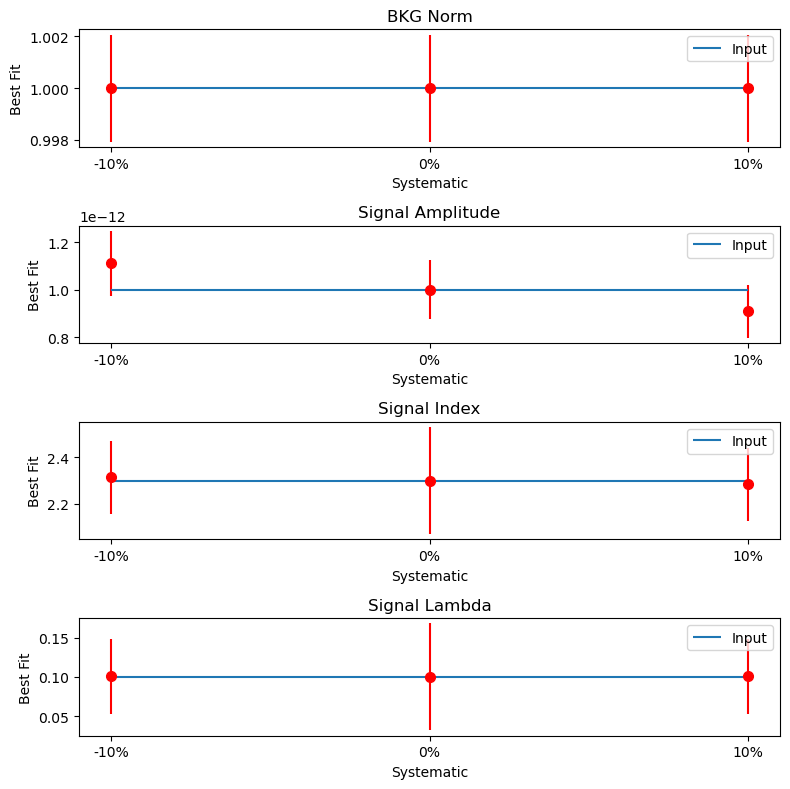

In [15]:
fig, axs = plt.subplots(4,1, figsize=(8,8))

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")
axs[3].set_title("Signal Lambda")


labels = ['-10%', '0%', '10%']

for i, a in enumerate(norms[1:]):
    axs[0].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red', markersize=7)
axs[0].hlines( norms[0][0], 1, 3, label = "Input")

for i, a in enumerate(amplitudes[1:]):
    axs[1].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red', markersize=7)
axs[1].hlines( amplitudes[0][0], 1, 3, label = "Input")

for i, a in enumerate(indices[1:]):
    axs[2].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red', markersize=7)
axs[2].hlines( indices[0][0], 1, 3, label = "Input")

for i, a in enumerate(lambdas[1:]):
    axs[3].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red', markersize=7)
axs[3].hlines( lambdas[0][0], 1, 3, label = "Input")

plt.tight_layout()
for a in axs:
    a.legend(); 
    a.set_ylabel('Best Fit'); 
    a.set_xlabel('Systematic'); 
    a.set_xticks(np.arange(3)+1,labels)

plt.tight_layout()    
fig.savefig("plots/1b_best_fit_parameters_standard.pdf")   


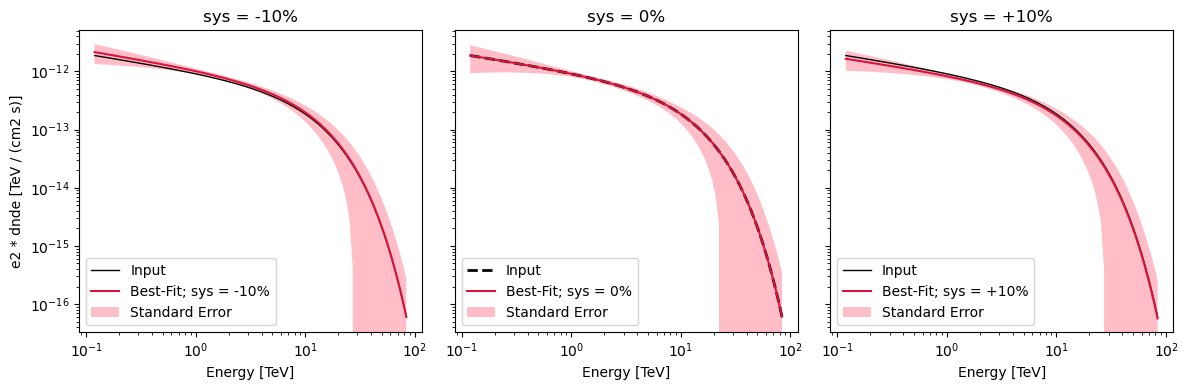

In [16]:
energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV

fig,axs = plt.subplots(1,3, sharey=True,figsize = (12,4))

for i,ax in enumerate(axs):
    if i ==1:
         dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
    else:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 1, )

dataset_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                label = "Best-Fit; sys = -10%", color = "crimson")
dataset_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )

dataset_cor.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],
                                label = "Best-Fit; sys = 0%", color = "crimson")
dataset_cor.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )

dataset_pos.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],
                                label = "Best-Fit; sys = +10%", color = "crimson")
dataset_pos.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
[a.legend() for a in axs]
axs[0].set_title("sys = -10%"); axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 

axs[1].set_ylabel('')
axs[2].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/1b_spectrum_standard.pdf")

## Dependency of Errors on shift & tilt

### Varying Shift with Fixed Tilt

In [9]:
%%time
amplitude_shift = []
index_shift = []
lambda_shift = []
norm_shift = []
errors_amplitude_shift = []
errors_index_shift = []
errors_lambda_shift = []
errors_norm_shift = []

amplitude_shift_fail = []
index_shift_fail = []
lambda_shift_fail = []
norm_shift_fail = []
errors_amplitude_shift_fail = []
errors_index_shift_fail = []
errors_lambda_shift_fail = []
errors_norm_shift_fail = []

tilt_fixed = 0.015

for i, shift in enumerate(np.linspace(-0.11, 0.11, 45)):
    print('shift', i, '=', shift)
    sys_d = sys_dataset(dataset_asimov, shift, tilt_fixed, False)
    dataset_shift = sys_d.create_dataset()
    
    fit_shift = Fit(store_trace=False)
    minuit_opts = {"tol": 0.001, "strategy": 2}
    fit_shift.backend = "minuit"
    fit_shift.optimize_opts = minuit_opts
    result_shift = fit_shift.run([dataset_shift])
    
    if result_shift.success:
        amplitude_shift.append((shift, dataset_shift.models.parameters['amplitude'].value))
        index_shift.append((shift, dataset_shift.models.parameters['index'].value))
        lambda_shift.append((shift, dataset_shift.models.parameters['lambda_'].value))
        norm_shift.append((shift, dataset_shift.models.parameters['norm'].value))

        errors_amplitude_shift.append((shift, dataset_shift.models.parameters['amplitude'].error))
        errors_index_shift.append((shift, dataset_shift.models.parameters['index'].error))
        errors_lambda_shift.append((shift, dataset_shift.models.parameters['lambda_'].error))
        errors_norm_shift.append((shift, dataset_shift.models.parameters['norm'].error))
    else:
        print('Fail')
        amplitude_shift_fail.append((shift, dataset_shift.models.parameters['amplitude'].value))
        index_shift_fail.append((shift, dataset_shift.models.parameters['index'].value))
        lambda_shift_fail.append((shift, dataset_shift.models.parameters['lambda_'].value))
        norm_shift_fail.append((shift, dataset_shift.models.parameters['norm'].value))

        errors_amplitude_shift_fail.append((shift, dataset_shift.models.parameters['amplitude'].error))
        errors_index_shift_fail.append((shift, dataset_shift.models.parameters['index'].error))
        errors_lambda_shift_fail.append((shift, dataset_shift.models.parameters['lambda_'].error))
        errors_norm_shift_fail.append((shift, dataset_shift.models.parameters['norm'].error))
    
    np.savetxt('data/1b_amplitude_shift.txt', amplitude_shift)
    np.savetxt('data/1b_index_shift.txt', index_shift)
    np.savetxt('data/1b_lambda_shift.txt', lambda_shift)
    np.savetxt('data/1b_norm_shift.txt', norm_shift)
    np.savetxt('data/1b_errors_amplitude_shift.txt', errors_amplitude_shift)
    np.savetxt('data/1b_errors_index_shift.txt', errors_index_shift)
    np.savetxt('data/1b_errors_lambda_shift.txt', errors_lambda_shift)
    np.savetxt('data/1b_errors_norm_shift.txt', errors_norm_shift)
               
    np.savetxt('data/1b_amplitude_shift_fail.txt', amplitude_shift_fail)
    np.savetxt('data/1b_index_shift_fail.txt', index_shift_fail)
    np.savetxt('data/1b_lambda_shift_fail.txt', lambda_shift_fail)
    np.savetxt('data/1b_norm_shift_fail.txt', norm_shift_fail)
    np.savetxt('data/1b_errors_amplitude_shift_fail.txt', errors_amplitude_shift_fail)
    np.savetxt('data/1b_errors_index_shift_fail.txt', errors_index_shift_fail)
    np.savetxt('data/1b_errors_lambda_shift_fail.txt', errors_lambda_shift_fail)
    np.savetxt('data/1b_errors_norm_shift_fail.txt', errors_norm_shift_fail)
    #print(dataset_shift.models.parameters['amplitude'].error)
    #print(dataset_shift.models.parameters['index'].error)

shift 0 = -0.11
Fail
shift 1 = -0.105
Fail
shift 2 = -0.1
Fail
shift 3 = -0.095
Fail
shift 4 = -0.09
Fail
shift 5 = -0.08499999999999999
Fail
shift 6 = -0.08
Fail
shift 7 = -0.075
Fail
shift 8 = -0.07
Fail
shift 9 = -0.065
Fail
shift 10 = -0.06
Fail
shift 11 = -0.055
Fail
shift 12 = -0.05
Fail
shift 13 = -0.045
Fail
shift 14 = -0.039999999999999994
Fail
shift 15 = -0.035
Fail
shift 16 = -0.03
Fail
shift 17 = -0.024999999999999994
Fail
shift 18 = -0.020000000000000004
Fail
shift 19 = -0.015
Fail
shift 20 = -0.009999999999999995
Fail
shift 21 = -0.0050000000000000044
Fail
shift 22 = 0.0
Fail
shift 23 = 0.0050000000000000044
Fail
shift 24 = 0.009999999999999995
Fail
shift 25 = 0.015
Fail
shift 26 = 0.020000000000000004
Fail
shift 27 = 0.02500000000000001
Fail
shift 28 = 0.030000000000000013
Fail
shift 29 = 0.03499999999999999
Fail
shift 30 = 0.039999999999999994
Fail
shift 31 = 0.045
Fail
shift 32 = 0.05
Fail
shift 33 = 0.05500000000000001
Fail
shift 34 = 0.06000000000000001
Fail
shift 35

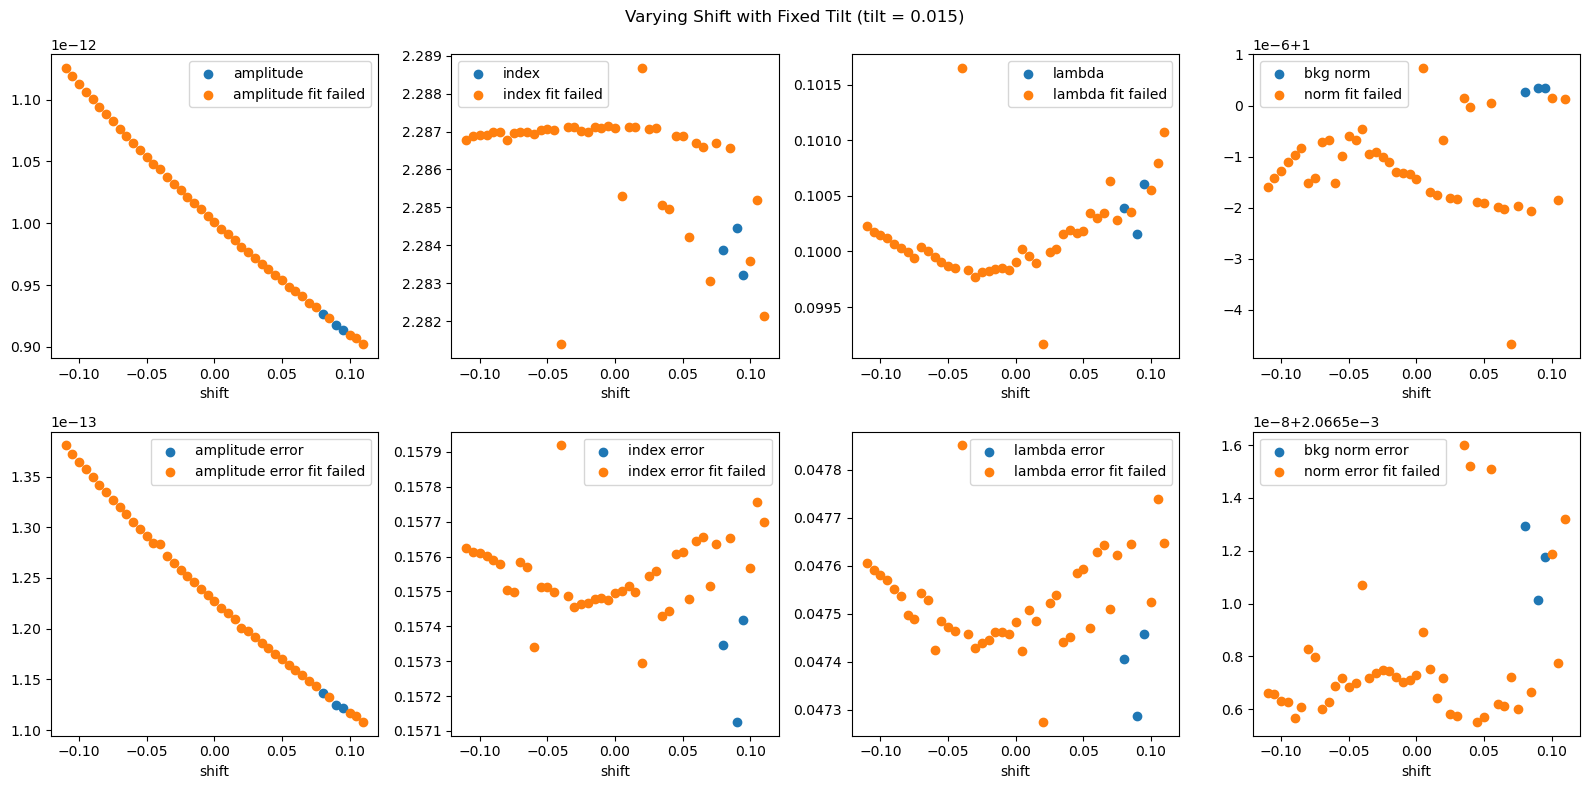

In [10]:
fig, ax = plt.subplots(2,4, figsize=(16,8))

ax[0][0].scatter(*zip(*amplitude_shift), label='amplitude')  
ax[0][1].scatter(*zip(*index_shift), label='index')
ax[0][2].scatter(*zip(*lambda_shift), label='lambda')
ax[0][3].scatter(*zip(*norm_shift), label='bkg norm')

ax[1][0].scatter(*zip(*errors_amplitude_shift), label='amplitude error')  
ax[1][1].scatter(*zip(*errors_index_shift), label='index error')
ax[1][2].scatter(*zip(*errors_lambda_shift), label='lambda error')
ax[1][3].scatter(*zip(*errors_norm_shift), label='bkg norm error')

if bool(amplitude_shift_fail):
    ax[0][0].scatter(*zip(*amplitude_shift_fail), label='amplitude fit failed', color='tab:orange')  
    ax[0][1].scatter(*zip(*index_shift_fail), label='index fit failed', color='tab:orange')
    ax[0][2].scatter(*zip(*lambda_shift_fail), label='lambda fit failed', color='tab:orange')
    ax[0][3].scatter(*zip(*norm_shift_fail), label='norm fit failed', color='tab:orange')

    ax[1][0].scatter(*zip(*errors_amplitude_shift_fail), label='amplitude error fit failed', color='tab:orange')  
    ax[1][1].scatter(*zip(*errors_index_shift_fail), label='index error fit failed', color='tab:orange')
    ax[1][2].scatter(*zip(*errors_lambda_shift_fail), label='lambda error fit failed', color='tab:orange')
    ax[1][3].scatter(*zip(*errors_norm_shift_fail), label='norm error fit failed', color='tab:orange')

ax[0][0].set_xlabel('shift');ax[0][1].set_xlabel('shift');ax[0][2].set_xlabel('shift');ax[0][3].set_xlabel('shift')
ax[1][0].set_xlabel('shift');ax[1][1].set_xlabel('shift');ax[1][2].set_xlabel('shift');ax[1][3].set_xlabel('shift')
ax[0][0].legend();ax[0][1].legend();ax[0][2].legend();ax[0][3].legend()
ax[1][0].legend();ax[1][1].legend();ax[1][2].legend();ax[1][3].legend()
plt.suptitle(f'Varying Shift with Fixed Tilt (tilt = {tilt_fixed})')
plt.tight_layout()
fig.savefig("plots/1b_varying_shift.pdf") 
plt.show()

In [5]:
%%time
amplitude_shift = []
index_shift = []
lambda_shift = []
norm_shift = []
errors_amplitude_shift = []
errors_index_shift = []
errors_lambda_shift = []
errors_norm_shift = []

amplitude_shift_fail = []
index_shift_fail = []
lambda_shift_fail = []
norm_shift_fail = []
errors_amplitude_shift_fail = []
errors_index_shift_fail = []
errors_lambda_shift_fail = []
errors_norm_shift_fail = []

tilt_fixed = 0.0

for i, shift in enumerate(np.linspace(-0.11, 0.11, 45)):
    print('shift', i, '=', shift)
    sys_d = sys_dataset(dataset_asimov, shift, tilt_fixed, False)
    dataset_shift = sys_d.create_dataset()
    
    fit_shift = Fit(store_trace=False)
    minuit_opts = {"tol": 0.001, "strategy": 2}
    fit_shift.backend = "minuit"
    fit_shift.optimize_opts = minuit_opts
    result_shift = fit_shift.run([dataset_shift])
    
    if result_shift.success:
        amplitude_shift.append((shift, dataset_shift.models.parameters['amplitude'].value))
        index_shift.append((shift, dataset_shift.models.parameters['index'].value))
        lambda_shift.append((shift, dataset_shift.models.parameters['lambda_'].value))
        norm_shift.append((shift, dataset_shift.models.parameters['norm'].value))

        errors_amplitude_shift.append((shift, dataset_shift.models.parameters['amplitude'].error))
        errors_index_shift.append((shift, dataset_shift.models.parameters['index'].error))
        errors_lambda_shift.append((shift, dataset_shift.models.parameters['lambda_'].error))
        errors_norm_shift.append((shift, dataset_shift.models.parameters['norm'].error))
    else:
        print('Fail')
        amplitude_shift_fail.append((shift, dataset_shift.models.parameters['amplitude'].value))
        index_shift_fail.append((shift, dataset_shift.models.parameters['index'].value))
        lambda_shift_fail.append((shift, dataset_shift.models.parameters['lambda_'].value))
        norm_shift_fail.append((shift, dataset_shift.models.parameters['norm'].value))

        errors_amplitude_shift_fail.append((shift, dataset_shift.models.parameters['amplitude'].error))
        errors_index_shift_fail.append((shift, dataset_shift.models.parameters['index'].error))
        errors_lambda_shift_fail.append((shift, dataset_shift.models.parameters['lambda_'].error))
        errors_norm_shift_fail.append((shift, dataset_shift.models.parameters['norm'].error))
    
    np.savetxt('data/1b_amplitude_shift_at_zero_tilt.txt', amplitude_shift)
    np.savetxt('data/1b_index_shift_at_zero_tilt.txt', index_shift)
    np.savetxt('data/1b_lambda_shift_at_zero_tilt.txt', lambda_shift)
    np.savetxt('data/1b_norm_shift_at_zero_tilt.txt', norm_shift)
    np.savetxt('data/1b_errors_amplitude_shift_at_zero_tilt.txt', errors_amplitude_shift)
    np.savetxt('data/1b_errors_index_shift_at_zero_tilt.txt', errors_index_shift)
    np.savetxt('data/1b_errors_lambda_shift_at_zero_tilt.txt', errors_lambda_shift)
    np.savetxt('data/1b_errors_norm_shift_at_zero_tilt.txt', errors_norm_shift)
               
    np.savetxt('data/1b_amplitude_shift_at_zero_tilt_fail.txt', amplitude_shift_fail)
    np.savetxt('data/1b_index_shift_at_zero_tilt_fail.txt', index_shift_fail)
    np.savetxt('data/1b_lambda_shift_at_zero_tilt_fail.txt', lambda_shift_fail)
    np.savetxt('data/1b_norm_shift_at_zero_tilt_fail.txt', norm_shift_fail)
    np.savetxt('data/1b_errors_amplitude_shift_at_zero_tilt_fail.txt', errors_amplitude_shift_fail)
    np.savetxt('data/1b_errors_index_shift_at_zero_tilt_fail.txt', errors_index_shift_fail)
    np.savetxt('data/1b_errors_lambda_shift_at_zero_tilt_fail.txt', errors_lambda_shift_fail)
    np.savetxt('data/1b_errors_norm_shift_at_zero_tilt_fail.txt', errors_norm_shift_fail)
    #print(dataset_shift.models.parameters['amplitude'].error)
    #print(dataset_shift.models.parameters['index'].error)

shift 0 = -0.11
Fail
shift 1 = -0.105
Fail
shift 2 = -0.1
Fail
shift 3 = -0.095
Fail
shift 4 = -0.09
Fail
shift 5 = -0.08499999999999999
shift 6 = -0.08
shift 7 = -0.075
shift 8 = -0.07
shift 9 = -0.065
shift 10 = -0.06
shift 11 = -0.055
shift 12 = -0.05
shift 13 = -0.045
shift 14 = -0.039999999999999994
shift 15 = -0.035
shift 16 = -0.03
shift 17 = -0.024999999999999994
shift 18 = -0.020000000000000004
shift 19 = -0.015
shift 20 = -0.009999999999999995
shift 21 = -0.0050000000000000044
shift 22 = 0.0
shift 23 = 0.0050000000000000044
shift 24 = 0.009999999999999995
shift 25 = 0.015
Fail
shift 26 = 0.020000000000000004
Fail
shift 27 = 0.02500000000000001
Fail
shift 28 = 0.030000000000000013
Fail
shift 29 = 0.03499999999999999
shift 30 = 0.039999999999999994
Fail
shift 31 = 0.045
Fail
shift 32 = 0.05
Fail
shift 33 = 0.05500000000000001
Fail
shift 34 = 0.06000000000000001
Fail
shift 35 = 0.06500000000000002
Fail
shift 36 = 0.06999999999999999
Fail
shift 37 = 0.075
Fail
shift 38 = 0.08
Fai

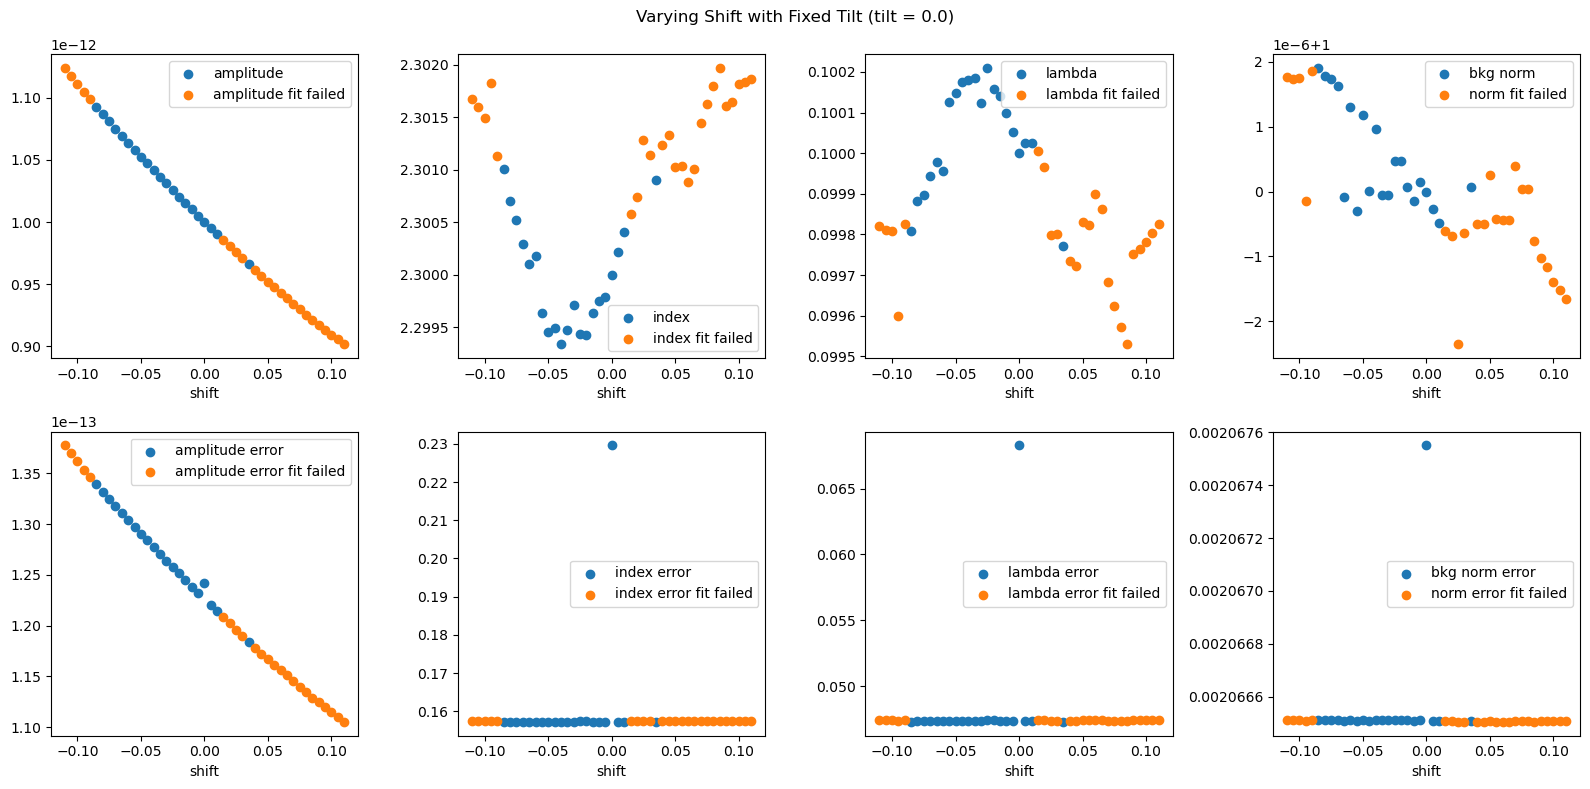

In [6]:
fig, ax = plt.subplots(2,4, figsize=(16,8))

ax[0][0].scatter(*zip(*amplitude_shift), label='amplitude')  
ax[0][1].scatter(*zip(*index_shift), label='index')
ax[0][2].scatter(*zip(*lambda_shift), label='lambda')
ax[0][3].scatter(*zip(*norm_shift), label='bkg norm')

ax[1][0].scatter(*zip(*errors_amplitude_shift), label='amplitude error')  
ax[1][1].scatter(*zip(*errors_index_shift), label='index error')
ax[1][2].scatter(*zip(*errors_lambda_shift), label='lambda error')
ax[1][3].scatter(*zip(*errors_norm_shift), label='bkg norm error')

if bool(amplitude_shift_fail):
    ax[0][0].scatter(*zip(*amplitude_shift_fail), label='amplitude fit failed', color='tab:orange')  
    ax[0][1].scatter(*zip(*index_shift_fail), label='index fit failed', color='tab:orange')
    ax[0][2].scatter(*zip(*lambda_shift_fail), label='lambda fit failed', color='tab:orange')
    ax[0][3].scatter(*zip(*norm_shift_fail), label='norm fit failed', color='tab:orange')

    ax[1][0].scatter(*zip(*errors_amplitude_shift_fail), label='amplitude error fit failed', color='tab:orange')  
    ax[1][1].scatter(*zip(*errors_index_shift_fail), label='index error fit failed', color='tab:orange')
    ax[1][2].scatter(*zip(*errors_lambda_shift_fail), label='lambda error fit failed', color='tab:orange')
    ax[1][3].scatter(*zip(*errors_norm_shift_fail), label='norm error fit failed', color='tab:orange')

ax[0][0].set_xlabel('shift');ax[0][1].set_xlabel('shift');ax[0][2].set_xlabel('shift');ax[0][3].set_xlabel('shift')
ax[1][0].set_xlabel('shift');ax[1][1].set_xlabel('shift');ax[1][2].set_xlabel('shift');ax[1][3].set_xlabel('shift')
ax[0][0].legend();ax[0][1].legend();ax[0][2].legend();ax[0][3].legend()
ax[1][0].legend();ax[1][1].legend();ax[1][2].legend();ax[1][3].legend()
plt.suptitle(f'Varying Shift with Fixed Tilt (tilt = {tilt_fixed})')
plt.tight_layout()
fig.savefig("plots/1b_varying_shift_at_zero_tilt.pdf") 
plt.show()

### Varying Tilt with Fixed Shift

In [17]:
%%time
amplitude_tilt = []
index_tilt = []
lambda_tilt = []
norm_tilt = []
errors_amplitude_tilt = []
errors_index_tilt = []
errors_lambda_tilt = []
errors_norm_tilt = []

amplitude_tilt_fail = []
index_tilt_fail = []
lambda_tilt_fail = []
norm_tilt_fail = []
errors_amplitude_tilt_fail = []
errors_index_tilt_fail = []
errors_lambda_tilt_fail = []
errors_norm_tilt_fail = []

shift_fixed = 0.1 #0.085

for i, tilt in enumerate(np.linspace(-0.02, 0.02, 45)): #np.linspace(-0.11, 0.11, 45)
    print('tilt', i, '=', tilt)
    sys_d = sys_dataset(dataset_asimov, shift_fixed, tilt, False)
    dataset_tilt = sys_d.create_dataset()
    
    fit_tilt = Fit(store_trace=False)
    minuit_opts = {"tol": 0.001, "strategy": 2}
    fit_tilt.backend = "minuit"
    fit_tilt.optimize_opts = minuit_opts
    result_tilt = fit_tilt.run([dataset_tilt])
    
    if result_tilt.success:
        #print(result_tilt.success)
        amplitude_tilt.append((tilt, dataset_tilt.models.parameters['amplitude'].value))
        index_tilt.append((tilt, dataset_tilt.models.parameters['index'].value))
        lambda_tilt.append((tilt, dataset_tilt.models.parameters['lambda_'].value))
        norm_tilt.append((tilt, dataset_tilt.models.parameters['norm'].value))

        errors_amplitude_tilt.append((tilt, dataset_tilt.models.parameters['amplitude'].error))
        errors_index_tilt.append((tilt, dataset_tilt.models.parameters['index'].error))
        errors_lambda_tilt.append((tilt, dataset_tilt.models.parameters['lambda_'].error))
        errors_norm_tilt.append((tilt, dataset_tilt.models.parameters['norm'].error))
    else:
        print('Fail')
        amplitude_tilt_fail.append((tilt, dataset_tilt.models.parameters['amplitude'].value))
        index_tilt_fail.append((tilt, dataset_tilt.models.parameters['index'].value))
        lambda_tilt_fail.append((tilt, dataset_tilt.models.parameters['lambda_'].value))
        norm_tilt_fail.append((tilt, dataset_tilt.models.parameters['norm'].value))

        errors_amplitude_tilt_fail.append((tilt, dataset_tilt.models.parameters['amplitude'].error))
        errors_index_tilt_fail.append((tilt, dataset_tilt.models.parameters['index'].error))
        errors_lambda_tilt_fail.append((tilt, dataset_tilt.models.parameters['lambda_'].error))
        errors_norm_tilt_fail.append((tilt, dataset_tilt.models.parameters['norm'].error))
    
    np.savetxt('data/1b_amplitude_tilt.txt', amplitude_tilt)
    np.savetxt('data/1b_index_tilt.txt', index_tilt)
    np.savetxt('data/1b_lambda_tilt.txt', lambda_tilt)
    np.savetxt('data/1b_norm_tilt.txt', norm_tilt)
    np.savetxt('data/1b_errors_amplitude_tilt.txt', errors_amplitude_tilt)
    np.savetxt('data/1b_errors_index_tilt.txt', errors_index_tilt)
    np.savetxt('data/1b_errors_lambda_tilt.txt', errors_lambda_tilt)
    np.savetxt('data/1b_errors_norm_tilt.txt', errors_norm_tilt)
               
    np.savetxt('data/1b_amplitude_tilt_fail.txt', amplitude_tilt_fail)
    np.savetxt('data/1b_index_tilt_fail.txt', index_tilt_fail)
    np.savetxt('data/1b_lambda_tilt_fail.txt', lambda_tilt_fail)
    np.savetxt('data/1b_norm_tilt_fail.txt', norm_tilt_fail)
    np.savetxt('data/1b_errors_amplitude_tilt_fail.txt', errors_amplitude_tilt_fail)
    np.savetxt('data/1b_errors_index_tilt_fail.txt', errors_index_tilt_fail)
    np.savetxt('data/1b_errors_lambda_tilt_fail.txt', errors_lambda_tilt_fail)
    np.savetxt('data/1b_errors_norm_tilt_fail.txt', errors_norm_tilt_fail)
    #print(dataset_tilt.models.parameters['amplitude'].error)
    #print(dataset_tilt.models.parameters['index'].error)

tilt 0 = -0.02
Fail
tilt 1 = -0.019090909090909092
Fail
tilt 2 = -0.01818181818181818
Fail
tilt 3 = -0.017272727272727273
Fail
tilt 4 = -0.016363636363636365
Fail
tilt 5 = -0.015454545454545455
Fail
tilt 6 = -0.014545454545454545
Fail
tilt 7 = -0.013636363636363637
Fail
tilt 8 = -0.012727272727272728
Fail
tilt 9 = -0.011818181818181818
Fail
tilt 10 = -0.01090909090909091
tilt 11 = -0.01
tilt 12 = -0.00909090909090909
tilt 13 = -0.008181818181818182
tilt 14 = -0.007272727272727273
tilt 15 = -0.006363636363636365
tilt 16 = -0.005454545454545455
tilt 17 = -0.004545454545454545
tilt 18 = -0.0036363636363636355
Fail
tilt 19 = -0.0027272727272727275
Fail
tilt 20 = -0.0018181818181818195
Fail
tilt 21 = -0.000909090909090908
Fail
tilt 22 = 0.0
Fail
tilt 23 = 0.000909090909090908
Fail
tilt 24 = 0.0018181818181818195
Fail
tilt 25 = 0.0027272727272727275
Fail
tilt 26 = 0.0036363636363636355
Fail
tilt 27 = 0.0045454545454545435
Fail
tilt 28 = 0.005454545454545455
Fail
tilt 29 = 0.00636363636363636

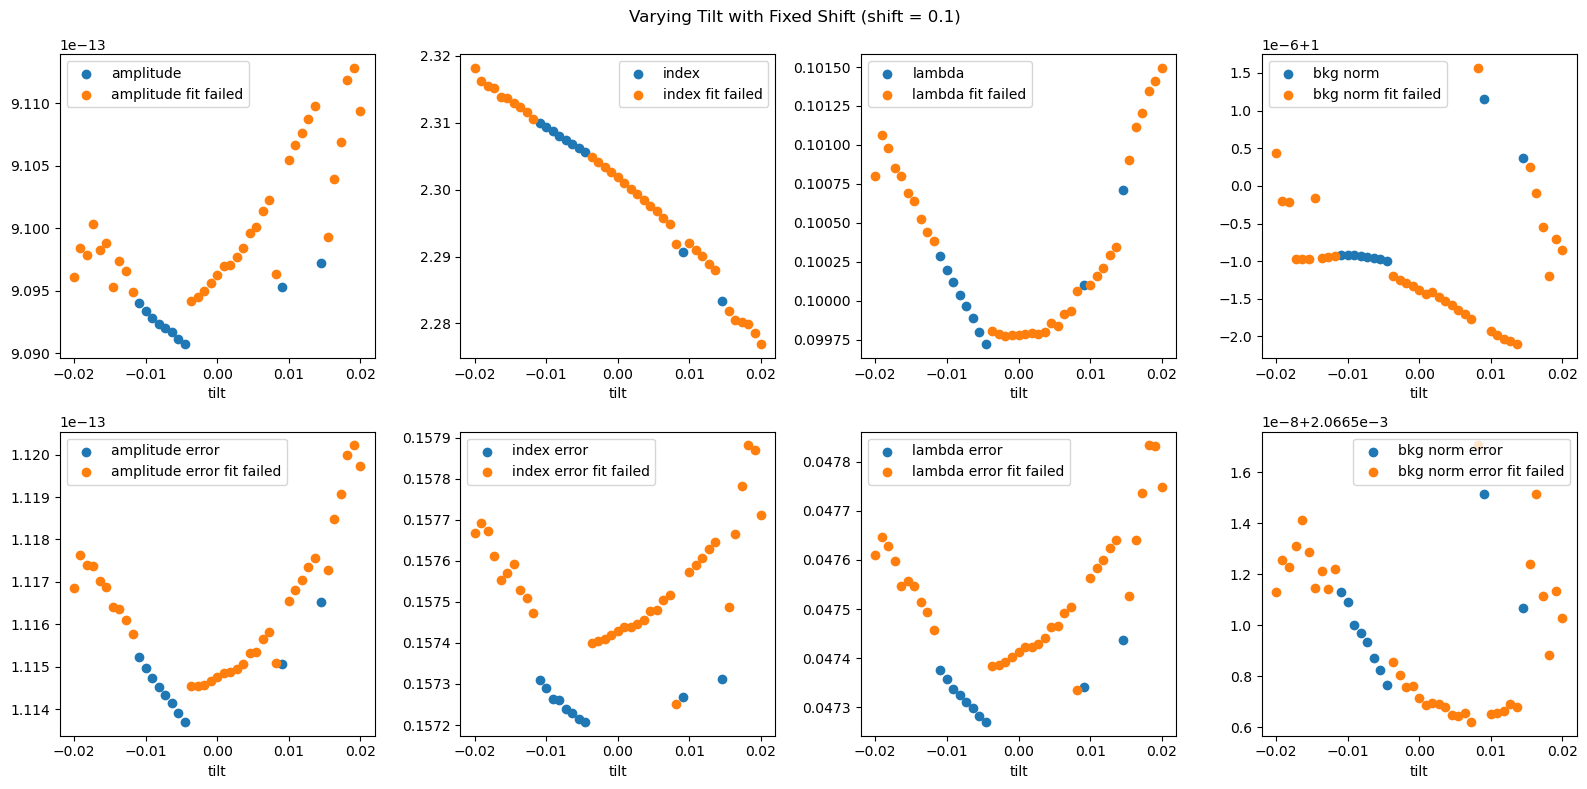

In [18]:
fig, ax = plt.subplots(2,4, figsize=(16,8))

ax[0][0].scatter(*zip(*amplitude_tilt), label='amplitude')  
ax[0][1].scatter(*zip(*index_tilt), label='index')
ax[0][2].scatter(*zip(*lambda_tilt), label='lambda')
ax[0][3].scatter(*zip(*norm_tilt), label='bkg norm')

ax[1][0].scatter(*zip(*errors_amplitude_tilt), label='amplitude error')  
ax[1][1].scatter(*zip(*errors_index_tilt), label='index error')
ax[1][2].scatter(*zip(*errors_lambda_tilt), label='lambda error')
ax[1][3].scatter(*zip(*errors_norm_tilt), label='bkg norm error')

if bool(amplitude_tilt_fail):
    ax[0][0].scatter(*zip(*amplitude_tilt_fail), label='amplitude fit failed', color='tab:orange')  
    ax[0][1].scatter(*zip(*index_tilt_fail), label='index fit failed', color='tab:orange')
    ax[0][2].scatter(*zip(*lambda_tilt_fail), label='lambda fit failed', color='tab:orange')
    ax[0][3].scatter(*zip(*norm_tilt_fail), label='bkg norm fit failed', color='tab:orange')

    ax[1][0].scatter(*zip(*errors_amplitude_tilt_fail), label='amplitude error fit failed', color='tab:orange')  
    ax[1][1].scatter(*zip(*errors_index_tilt_fail), label='index error fit failed', color='tab:orange')
    ax[1][2].scatter(*zip(*errors_lambda_tilt_fail), label='lambda error fit failed', color='tab:orange')
    ax[1][3].scatter(*zip(*errors_norm_tilt_fail), label='bkg norm error fit failed', color='tab:orange')

ax[0][0].set_xlabel('tilt');ax[0][1].set_xlabel('tilt');ax[0][2].set_xlabel('tilt');ax[0][3].set_xlabel('tilt')
ax[1][0].set_xlabel('tilt');ax[1][1].set_xlabel('tilt');ax[1][2].set_xlabel('tilt');ax[1][3].set_xlabel('tilt')
ax[0][0].legend();ax[0][1].legend();ax[0][2].legend();ax[0][3].legend()
ax[1][0].legend();ax[1][1].legend();ax[1][2].legend();ax[1][3].legend()
plt.suptitle(f'Varying Tilt with Fixed Shift (shift = {shift_fixed})')
plt.tight_layout()
fig.savefig("plots/1b_varying_tilt.pdf") 
plt.show()

In [7]:
%%time
amplitude_tilt = []
index_tilt = []
lambda_tilt = []
norm_tilt = []
errors_amplitude_tilt = []
errors_index_tilt = []
errors_lambda_tilt = []
errors_norm_tilt = []

amplitude_tilt_fail = []
index_tilt_fail = []
lambda_tilt_fail = []
norm_tilt_fail = []
errors_amplitude_tilt_fail = []
errors_index_tilt_fail = []
errors_lambda_tilt_fail = []
errors_norm_tilt_fail = []

shift_fixed = 0.0

#fig,ax = plt.subplots(2,1, sharex = True)
#npred = dataset_asimov.npred_signal().data.sum(axis = 2).sum(axis= 1)
#ax[0].plot(true_energy, npred, label = f"Input")
#ax[1].plot(true_energy, npred/npred, label = f"Input")

tilt_edge = 0.02
translate = 1 #interval centered at translate*shift_fixed

for i, tilt in enumerate(np.linspace(-tilt_edge + translate*shift_fixed, tilt_edge + translate*shift_fixed, 45)): #np.linspace(-0.11, 0.11, 45)
    print('tilt', i, '=', tilt)
    sys_d = sys_dataset(dataset_asimov, shift_fixed, tilt, False)
    dataset_tilt = sys_d.create_dataset()
    
    fit_tilt = Fit(store_trace=False)
    minuit_opts = {"tol": 0.001, "strategy": 2}
    fit_tilt.backend = "minuit"
    fit_tilt.optimize_opts = minuit_opts
    result_tilt = fit_tilt.run([dataset_tilt])
    
    

    energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV

    npred_tilt = dataset_tilt.npred_signal().data.sum(axis = 2).sum(axis= 1)

    if tilt > -0.001 and tilt < 0.001:
        color = 'tab:red'
    else:
        color = 'tab:blue'
    
    #ax[0].plot(true_energy, npred_tilt, color = color,
     #        label =f"{tilt}")
    
    #ax[1].plot(true_energy, npred_tilt/npred, color = color,
     #        label =f"{tilt}")
    
    
    if result_tilt.success:
        #print(result_tilt.success)
        amplitude_tilt.append((tilt, dataset_tilt.models.parameters['amplitude'].value))
        index_tilt.append((tilt, dataset_tilt.models.parameters['index'].value))
        lambda_tilt.append((tilt, dataset_tilt.models.parameters['lambda_'].value))
        norm_tilt.append((tilt, dataset_tilt.models.parameters['norm'].value))

        errors_amplitude_tilt.append((tilt, dataset_tilt.models.parameters['amplitude'].error))
        errors_index_tilt.append((tilt, dataset_tilt.models.parameters['index'].error))
        errors_lambda_tilt.append((tilt, dataset_tilt.models.parameters['lambda_'].error))
        errors_norm_tilt.append((tilt, dataset_tilt.models.parameters['norm'].error))
    else:
        print('Fail')
        amplitude_tilt_fail.append((tilt, dataset_tilt.models.parameters['amplitude'].value))
        index_tilt_fail.append((tilt, dataset_tilt.models.parameters['index'].value))
        lambda_tilt_fail.append((tilt, dataset_tilt.models.parameters['lambda_'].value))
        norm_tilt_fail.append((tilt, dataset_tilt.models.parameters['norm'].value))

        errors_amplitude_tilt_fail.append((tilt, dataset_tilt.models.parameters['amplitude'].error))
        errors_index_tilt_fail.append((tilt, dataset_tilt.models.parameters['index'].error))
        errors_lambda_tilt_fail.append((tilt, dataset_tilt.models.parameters['lambda_'].error))
        errors_norm_tilt_fail.append((tilt, dataset_tilt.models.parameters['norm'].error))
    
    np.savetxt('data/1b_amplitude_tilt_at_zero_shift.txt', amplitude_tilt)
    np.savetxt('data/1b_index_tilt_at_zero_shift.txt', index_tilt)
    np.savetxt('data/1b_lambda_tilt_at_zero_shift.txt', lambda_tilt)
    np.savetxt('data/1b_norm_tilt_at_zero_shift.txt', norm_tilt)
    np.savetxt('data/1b_errors_amplitude_tilt_at_zero_shift.txt', errors_amplitude_tilt)
    np.savetxt('data/1b_errors_index_tilt_at_zero_shift.txt', errors_index_tilt)
    np.savetxt('data/1b_errors_lambda_tilt_at_zero_shift.txt', errors_lambda_tilt)
    np.savetxt('data/1b_errors_norm_tilt_at_zero_shift.txt', errors_norm_tilt)
               
    np.savetxt('data/1b_amplitude_tilt_at_zero_shift_fail.txt', amplitude_tilt_fail)
    np.savetxt('data/1b_index_tilt_at_zero_shift_fail.txt', index_tilt_fail)
    np.savetxt('data/1b_lambda_tilt_at_zero_shift_fail.txt', lambda_tilt_fail)
    np.savetxt('data/1b_norm_tilt_at_zero_shift_fail.txt', norm_tilt_fail)
    np.savetxt('data/1b_errors_amplitude_tilt_at_zero_shift_fail.txt', errors_amplitude_tilt_fail)
    np.savetxt('data/1b_errors_index_tilt_at_zero_shift_fail.txt', errors_index_tilt_fail)
    np.savetxt('data/1b_errors_lambda_tilt_at_zero_shift_fail.txt', errors_lambda_tilt_fail)
    np.savetxt('data/1b_errors_norm_tilt_at_zero_shift_fail.txt', errors_norm_tilt_fail)
    #print(dataset_tilt.models.parameters['amplitude'].error)
    #print(dataset_tilt.models.parameters['index'].error)
    
#ax[0].loglog()
##ax[0].legend()
#ax[0].set_xlabel("Energy [TeV]")
#ax[0].set_ylabel("Predicted Counts")
##ax[1].legend()
#ax[1].set_xscale('log')
##for a in ax:
##    handles, labels = plt.gca().get_legend_handles_labels()
##    by_label = dict(zip(labels, handles))
##    a.legend(by_label.values(), by_label.keys(),
##            loc='center left', bbox_to_anchor=(1, 0.5))
#fig = plt.gcf()
##fig.savefig(f"plots/1b_counts_tilt_after_fit.pdf")

tilt 0 = -0.02
Fail
tilt 1 = -0.019090909090909092
Fail
tilt 2 = -0.01818181818181818
Fail
tilt 3 = -0.017272727272727273
Fail
tilt 4 = -0.016363636363636365
Fail
tilt 5 = -0.015454545454545455
Fail
tilt 6 = -0.014545454545454545
Fail
tilt 7 = -0.013636363636363637
Fail
tilt 8 = -0.012727272727272728
Fail
tilt 9 = -0.011818181818181818
Fail
tilt 10 = -0.01090909090909091
Fail
tilt 11 = -0.01
Fail
tilt 12 = -0.00909090909090909
Fail
tilt 13 = -0.008181818181818182
Fail
tilt 14 = -0.007272727272727273
Fail
tilt 15 = -0.006363636363636365
Fail
tilt 16 = -0.005454545454545455
tilt 17 = -0.004545454545454545
tilt 18 = -0.0036363636363636355
tilt 19 = -0.0027272727272727275
tilt 20 = -0.0018181818181818195
tilt 21 = -0.000909090909090908
tilt 22 = 0.0
tilt 23 = 0.000909090909090908
tilt 24 = 0.0018181818181818195
tilt 25 = 0.0027272727272727275
tilt 26 = 0.0036363636363636355
tilt 27 = 0.0045454545454545435
tilt 28 = 0.005454545454545455
Fail
tilt 29 = 0.006363636363636363
Fail
tilt 30 = 0.0

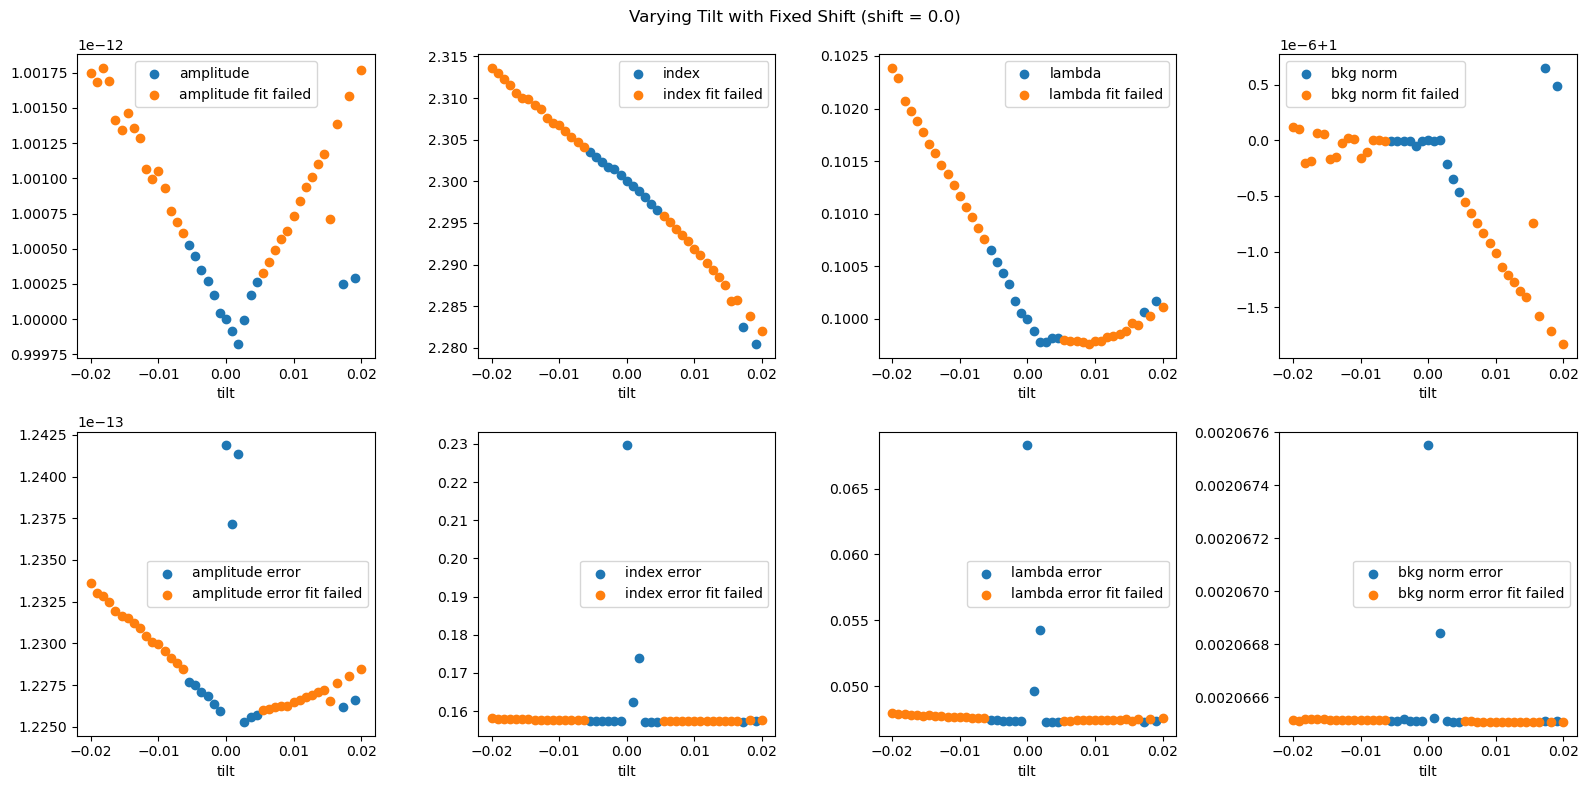

In [8]:
fig, ax = plt.subplots(2,4, figsize=(16,8))

ax[0][0].scatter(*zip(*amplitude_tilt), label='amplitude')  
ax[0][1].scatter(*zip(*index_tilt), label='index')
ax[0][2].scatter(*zip(*lambda_tilt), label='lambda')
ax[0][3].scatter(*zip(*norm_tilt), label='bkg norm')

ax[1][0].scatter(*zip(*errors_amplitude_tilt), label='amplitude error')  
ax[1][1].scatter(*zip(*errors_index_tilt), label='index error')
ax[1][2].scatter(*zip(*errors_lambda_tilt), label='lambda error')
ax[1][3].scatter(*zip(*errors_norm_tilt), label='bkg norm error')

if bool(amplitude_tilt_fail):
    ax[0][0].scatter(*zip(*amplitude_tilt_fail), label='amplitude fit failed', color='tab:orange')  
    ax[0][1].scatter(*zip(*index_tilt_fail), label='index fit failed', color='tab:orange')
    ax[0][2].scatter(*zip(*lambda_tilt_fail), label='lambda fit failed', color='tab:orange')
    ax[0][3].scatter(*zip(*norm_tilt_fail), label='bkg norm fit failed', color='tab:orange')

    ax[1][0].scatter(*zip(*errors_amplitude_tilt_fail), label='amplitude error fit failed', color='tab:orange')  
    ax[1][1].scatter(*zip(*errors_index_tilt_fail), label='index error fit failed', color='tab:orange')
    ax[1][2].scatter(*zip(*errors_lambda_tilt_fail), label='lambda error fit failed', color='tab:orange')
    ax[1][3].scatter(*zip(*errors_norm_tilt_fail), label='bkg norm error fit failed', color='tab:orange')

ax[0][0].set_xlabel('tilt');ax[0][1].set_xlabel('tilt');ax[0][2].set_xlabel('tilt');ax[0][3].set_xlabel('tilt')
ax[1][0].set_xlabel('tilt');ax[1][1].set_xlabel('tilt');ax[1][2].set_xlabel('tilt');ax[1][3].set_xlabel('tilt')
ax[0][0].legend();ax[0][1].legend();ax[0][2].legend();ax[0][3].legend()
ax[1][0].legend();ax[1][1].legend();ax[1][2].legend();ax[1][3].legend()
plt.suptitle(f'Varying Tilt with Fixed Shift (shift = {shift_fixed})')
plt.tight_layout()
fig.savefig("plots/1b_varying_tilt_at_zero_shift.pdf") 
plt.show()

### Varying Shift and Tilt

In [30]:
%%time
from numpy import savetxt, loadtxt
compute = False

amplitude_3d = []
index_3d = []
lambda_3d = []
norm_3d = []
errors_amplitude_3d = []
errors_index_3d = []
errors_lambda_3d = []
errors_norm_3d = []

amplitude_3d_fail = []
index_3d_fail = []
lambda_3d_fail = []
norm_3d_fail = []
errors_amplitude_3d_fail = []
errors_index_3d_fail = []
errors_lambda_3d_fail = []
errors_norm_3d_fail = []

if compute:
    for i, shift in enumerate(np.linspace(-0.11, 0.11, 45)):

        for j, tilt in enumerate(np.linspace(-0.022, 0.022, 31)):
            #print(shift, tilt)
            sys_d = sys_dataset(dataset_asimov, shift, tilt, False)
            dataset_3d = sys_d.create_dataset()
            
            fit_3d = Fit(store_trace=False)
            minuit_opts = {"tol": 0.001, "strategy": 2}
            fit_3d.backend = "minuit"
            fit_3d.optimize_opts = minuit_opts
            result = fit_3d.run([dataset_3d])
            
            if result.success:
                amplitude_3d.append((shift, tilt, dataset_3d.models.parameters['amplitude'].value))
                index_3d.append((shift, tilt, dataset_3d.models.parameters['index'].value))
                lambda_3d.append((shift, tilt, dataset_3d.models.parameters['lambda_'].value))
                norm_3d.append((shift, tilt, dataset_3d.models.parameters['norm'].value))

                errors_amplitude_3d.append((shift, tilt, dataset_3d.models.parameters['amplitude'].error))
                errors_index_3d.append((shift, tilt, dataset_3d.models.parameters['index'].error))
                errors_lambda_3d.append((shift, tilt, dataset_3d.models.parameters['lambda_'].error))
                errors_norm_3d.append((shift, tilt, dataset_3d.models.parameters['norm'].error))
            else:
                print('Fail')
                amplitude_3d_fail.append((shift, tilt, dataset_3d.models.parameters['amplitude'].value))
                index_3d_fail.append((shift, tilt, dataset_3d.models.parameters['index'].value))
                lambda_3d_fail.append((shift, tilt, dataset_3d.models.parameters['lambda_'].value))
                norm_3d_fail.append((shift, tilt, dataset_3d.models.parameters['norm'].value))

                errors_amplitude_3d_fail.append((shift, tilt, dataset_3d.models.parameters['amplitude'].error))
                errors_index_3d_fail.append((shift, tilt, dataset_3d.models.parameters['index'].error))
                errors_lambda_3d_fail.append((shift, tilt, dataset_3d.models.parameters['lambda_'].error)) 
                errors_norm_3d_fail.append((shift, tilt, dataset_3d.models.parameters['norm'].error))
                
    np.savetxt('data/1b_amplitude_3d.txt', amplitude_3d)
    np.savetxt('data/1b_index_3d.txt', index_3d)
    np.savetxt('data/1b_lambda_3d.txt', lambda_3d)
    np.savetxt('data/1b_norm_3d.txt', norm_3d)
    np.savetxt('data/1b_errors_amplitude_3d.txt', errors_amplitude_3d)
    np.savetxt('data/1b_errors_index_3d.txt', errors_index_3d)
    np.savetxt('data/1b_errors_lambda_3d.txt', errors_lambda_3d)
    np.savetxt('data/1b_errors_norm_3d.txt', errors_norm_3d)
               
    np.savetxt('data/1b_amplitude_3d_fail.txt', amplitude_3d_fail)
    np.savetxt('data/1b_index_3d_fail.txt', index_3d_fail)
    np.savetxt('data/1b_lambda_3d_fail.txt', lambda_3d_fail)
    np.savetxt('data/1b_norm_3d_fail.txt', norm_3d_fail)
    np.savetxt('data/1b_errors_amplitude_3d_fail.txt', errors_amplitude_3d_fail)
    np.savetxt('data/1b_errors_index_3d_fail.txt', errors_index_3d_fail)
    np.savetxt('data/1b_errors_lambda_3d_fail.txt', errors_lambda_3d_fail)
    np.savetxt('data/1b_errors_norm_3d_fail.txt', errors_norm_3d_fail)
    
else:
    amplitude_3d = np.loadtxt('data/1b_amplitude_3d.txt')
    index_3d = np.loadtxt('data/1b_index_3d.txt')
    lambda_3d = np.loadtxt('data/1b_lambda_3d.txt')
    norm_3d = np.loadtxt('data/1b_norm_3d.txt')
    errors_amplitude_3d = np.loadtxt('data/1b_errors_amplitude_3d.txt')
    errors_index_3d = np.loadtxt('data/1b_errors_index_3d.txt')
    errors_lambda_3d = np.loadtxt('data/1b_errors_lambda_3d.txt')
    errors_norm_3d = np.loadtxt('data/1b_errors_norm_3d.txt')
               
    amplitude_3d_fail = np.loadtxt('data/1b_amplitude_3d_fail.txt')
    index_3d_fail = np.loadtxt('data/1b_index_3d_fail.txt')
    lambda_3d_fail = np.loadtxt('data/1b_lambda_3d_fail.txt')
    norm_3d_fail = np.loadtxt('data/1b_norm_3d_fail.txt')
    errors_amplitude_3d_fail = np.loadtxt('data/1b_errors_amplitude_3d_fail.txt')
    errors_index_3d_fail = np.loadtxt('data/1b_errors_index_3d_fail.txt')
    errors_lambda_3d_fail = np.loadtxt('data/1b_errors_lambda_3d_fail.txt')
    errors_norm_3d_fail = np.loadtxt('data/1b_errors_norm_3d_fail.txt')

Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail


In [20]:
#from numpy import savetxt, loadtxt
#np.savetxt('data/1b_amplitude_3d.txt', amplitude_3d)
#np.savetxt('data/1b_index_3d.txt', index_3d)
#np.savetxt('data/1b_lambda_3d.txt', lambda_3d)
#np.savetxt('data/1b_norm_3d.txt', norm_3d)
#np.savetxt('data/1b_errors_amplitude_3d.txt', errors_amplitude_3d)
#np.savetxt('data/1b_errors_index_3d.txt', errors_index_3d)
#np.savetxt('data/1b_errors_lambda_3d.txt', errors_lambda_3d)
#np.savetxt('data/1b_errors_norm_3d.txt', errors_norm_3d)
#
#np.savetxt('data/1b_amplitude_3d_fail.txt', amplitude_3d_fail)
#np.savetxt('data/1b_index_3d_fail.txt', index_3d_fail)
#np.savetxt('data/1b_lambda_3d_fail.txt', lambda_3d_fail)
#np.savetxt('data/1b_norm_3d_fail.txt', norm_3d_fail)
#np.savetxt('data/1b_errors_amplitude_3d_fail.txt', errors_amplitude_3d_fail)
#np.savetxt('data/1b_errors_index_3d_fail.txt', errors_index_3d_fail)
#np.savetxt('data/1b_errors_lambda_3d_fail.txt', errors_lambda_3d_fail)
#np.savetxt('data/1b_errors_norm_3d_fail.txt', errors_norm_3d_fail)

<IPython.core.display.Javascript object>


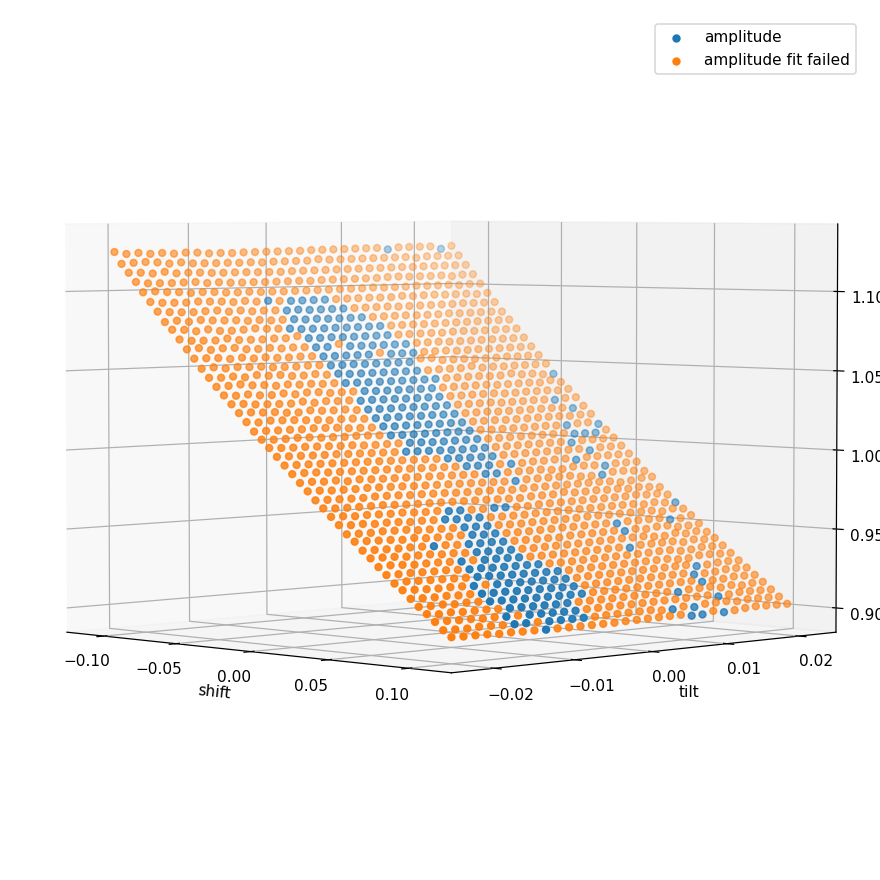

In [33]:
%matplotlib notebook
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection = '3d')

if bool(errors_amplitude_3d):#.size > 0:
    ax.scatter3D(*zip(*amplitude_3d), label='amplitude') 
if bool(errors_amplitude_3d_fail):#.size > 0:
    ax.scatter3D(*zip(*amplitude_3d_fail), label='amplitude fit failed', color='tab:orange') 
ax.view_init(3,315)
#ax.set_zlim3d(1.1e-13, 1.4e-13)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('amplitude')
ax.legend()
plt.tight_layout()
fig.savefig("plots/1b_tilt_shift_amplitude.pdf")
plt.show()


<IPython.core.display.Javascript object>


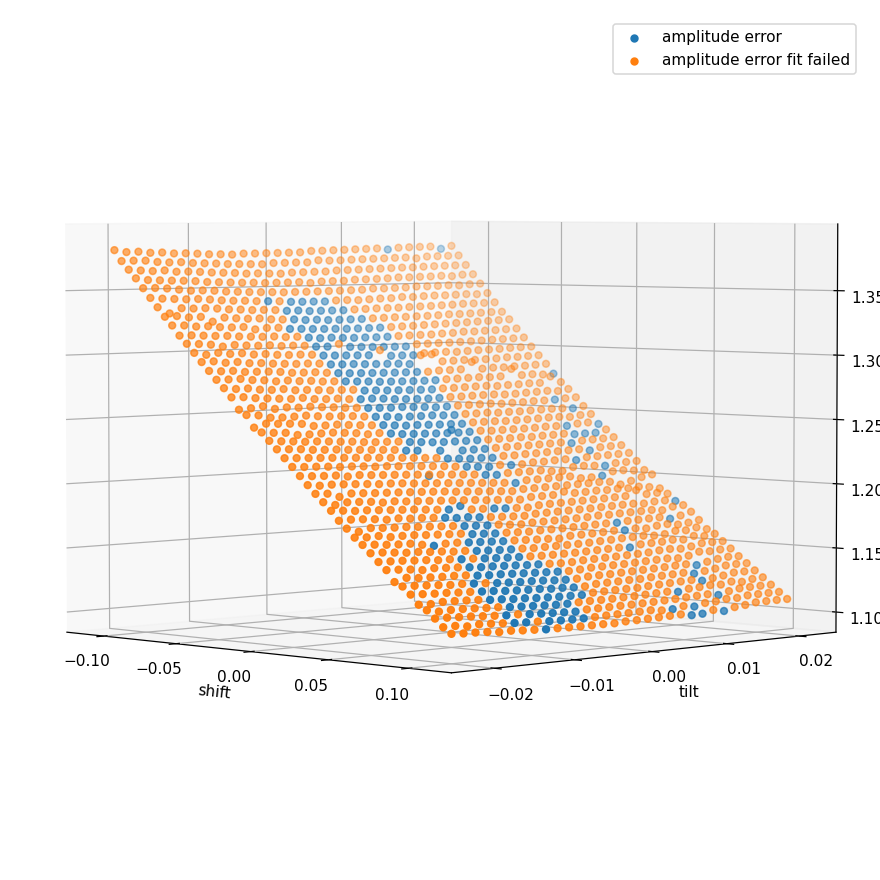

In [34]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection = '3d')

if bool(errors_amplitude_3d):#.size > 0:
    ax.scatter3D(*zip(*errors_amplitude_3d), label='amplitude error') 
if bool(errors_amplitude_3d_fail):#.size > 0:
    ax.scatter3D(*zip(*errors_amplitude_3d_fail), label='amplitude error fit failed', color='tab:orange') 
ax.view_init(3,315)
#ax.set_zlim3d(1.1e-13, 1.4e-13)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('amplitude error')
ax.legend()
plt.tight_layout()
fig.savefig("plots/1b_tilt_shift_amplitude_error.pdf")
plt.show()

<IPython.core.display.Javascript object>


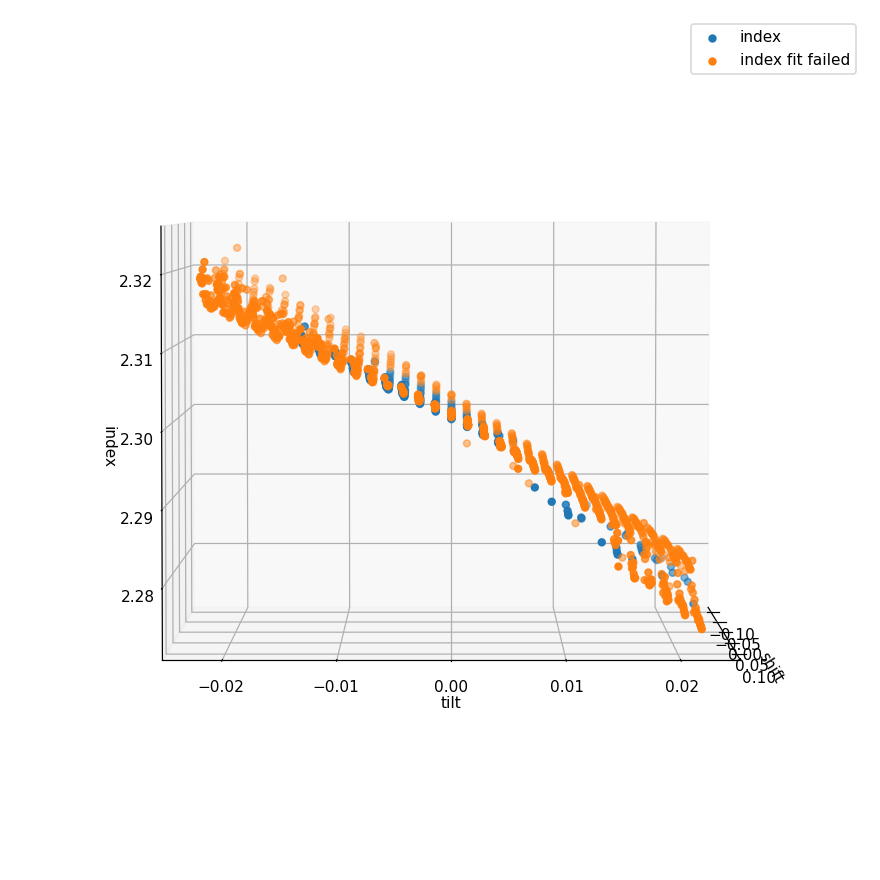

In [52]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

if bool(errors_index_3d):#.size > 0:
    ax.scatter3D(*zip(*index_3d), label='index') 
if bool(errors_index_3d_fail):#.size > 0:
    ax.scatter3D(*zip(*index_3d_fail), label='index fit failed', color='tab:orange') 
ax.view_init(3,0)
#ax.set_zlim3d(0.1565,0.1595)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('index')
ax.legend()
plt.tight_layout()
fig.savefig("plots/1b_tilt_shift_index.pdf")
plt.show()

<IPython.core.display.Javascript object>


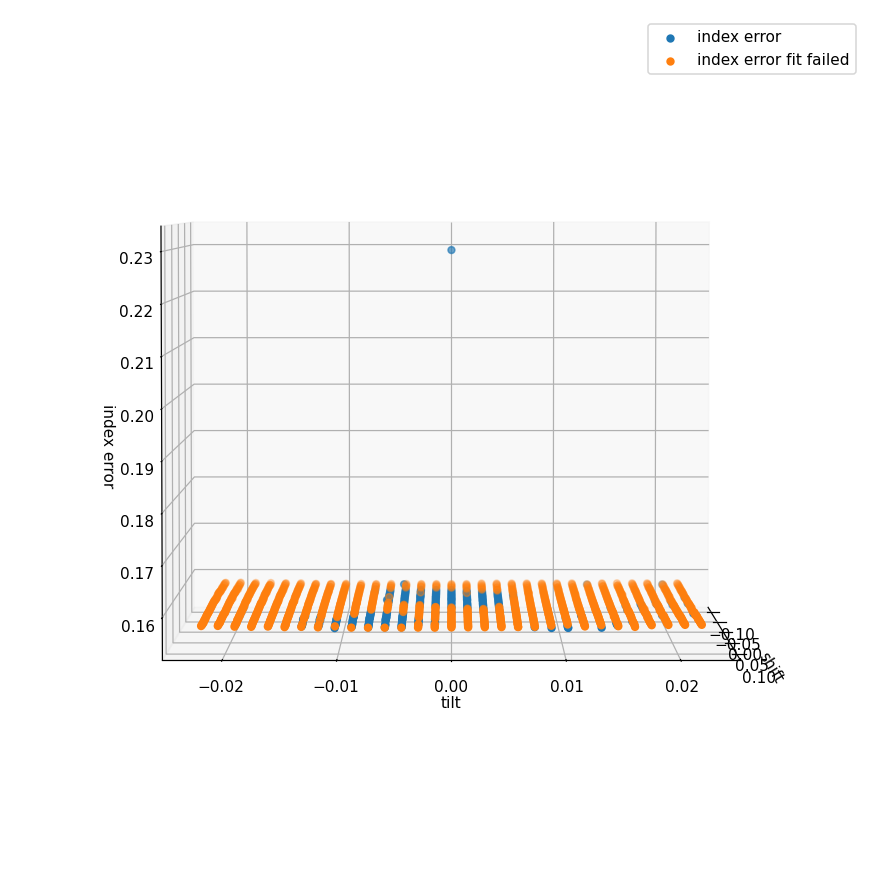

In [36]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

if bool(errors_index_3d):#.size > 0:
    ax.scatter3D(*zip(*errors_index_3d), label='index error') 
if bool(errors_index_3d_fail):#.size > 0:
    ax.scatter3D(*zip(*errors_index_3d_fail), label='index error fit failed', color='tab:orange') 
ax.view_init(3,0)
#ax.set_zlim3d(0.1565,0.1595)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('index error')
ax.legend()
plt.tight_layout()
fig.savefig("plots/1b_tilt_shift_index_error.pdf")
plt.show()

<IPython.core.display.Javascript object>


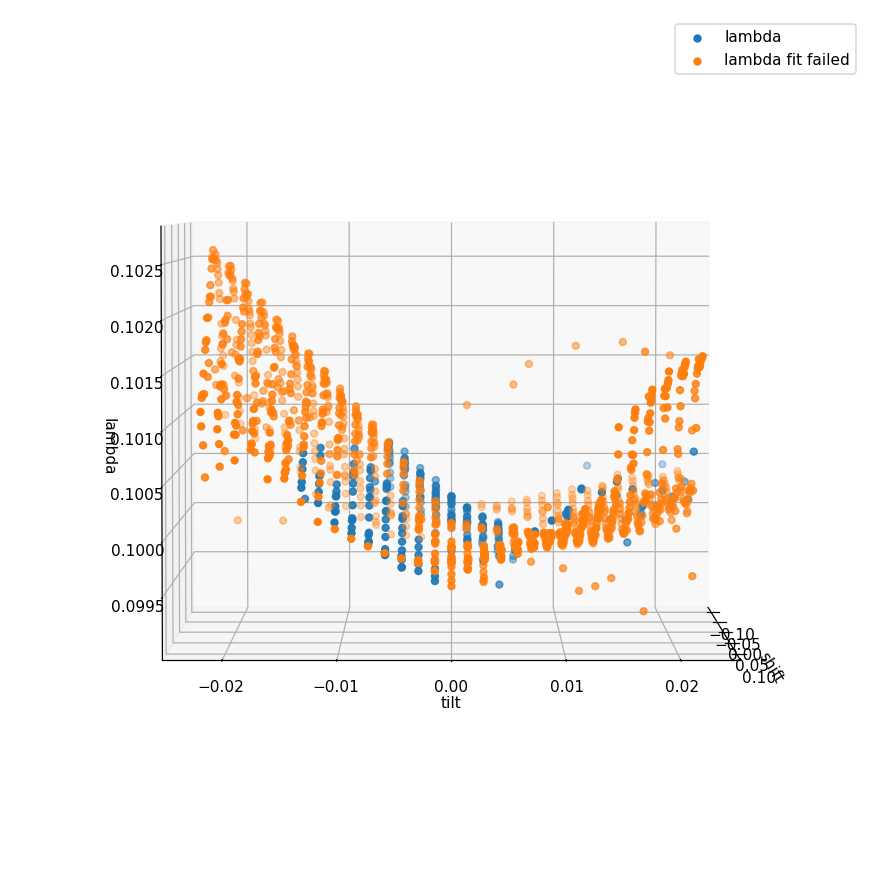

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

if bool(errors_lambda_3d):#.size > 0:
    ax.scatter3D(*zip(*lambda_3d), label='lambda') 
if bool(errors_lambda_3d_fail):#.size > 0:
    ax.scatter3D(*zip(*lambda_3d_fail), label='lambda fit failed', color='tab:orange')
ax.view_init(3,0)
#ax.set_zlim3d(0.0465,0.0490)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('lambda')
ax.legend()
plt.tight_layout()
fig.savefig("plots/1b_tilt_shift_lambda.pdf")
plt.show()

<IPython.core.display.Javascript object>


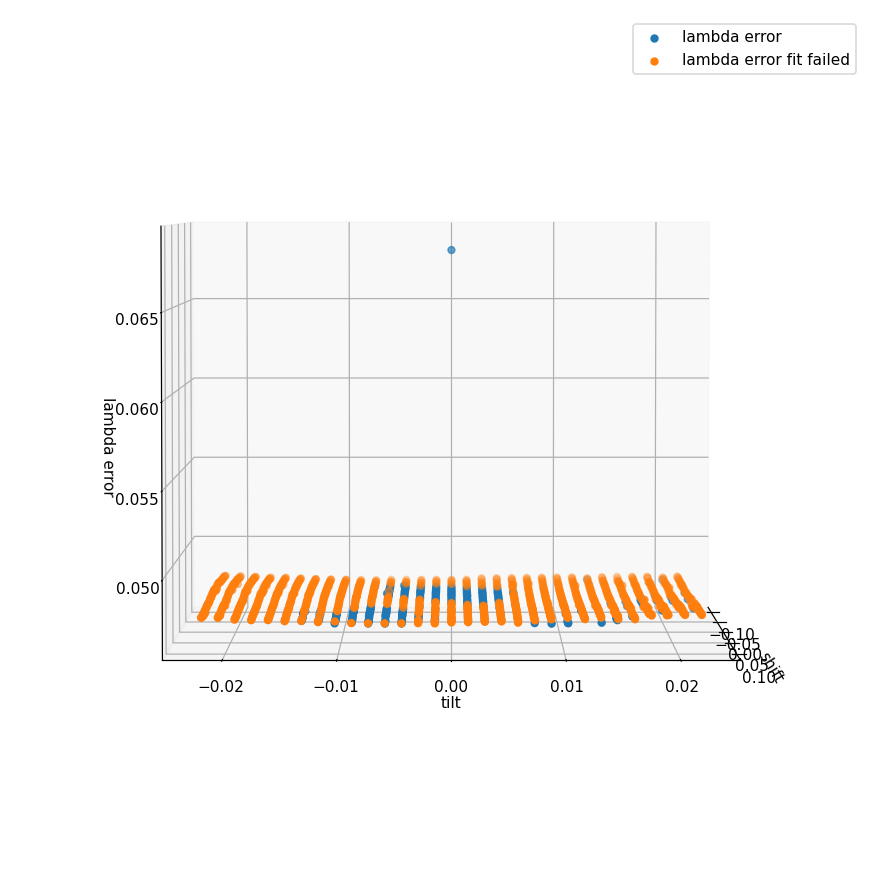

In [38]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

if bool(errors_lambda_3d):#.size > 0:
    ax.scatter3D(*zip(*errors_lambda_3d), label='lambda error') 
if bool(errors_lambda_3d_fail):#.size > 0:
    ax.scatter3D(*zip(*errors_lambda_3d_fail), label='lambda error fit failed', color='tab:orange')
ax.view_init(3,0)
#ax.set_zlim3d(0.0465,0.0490)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('lambda error')
ax.legend()
plt.tight_layout()
fig.savefig("plots/1b_tilt_shift_lambda_error.pdf")
plt.show()

<IPython.core.display.Javascript object>


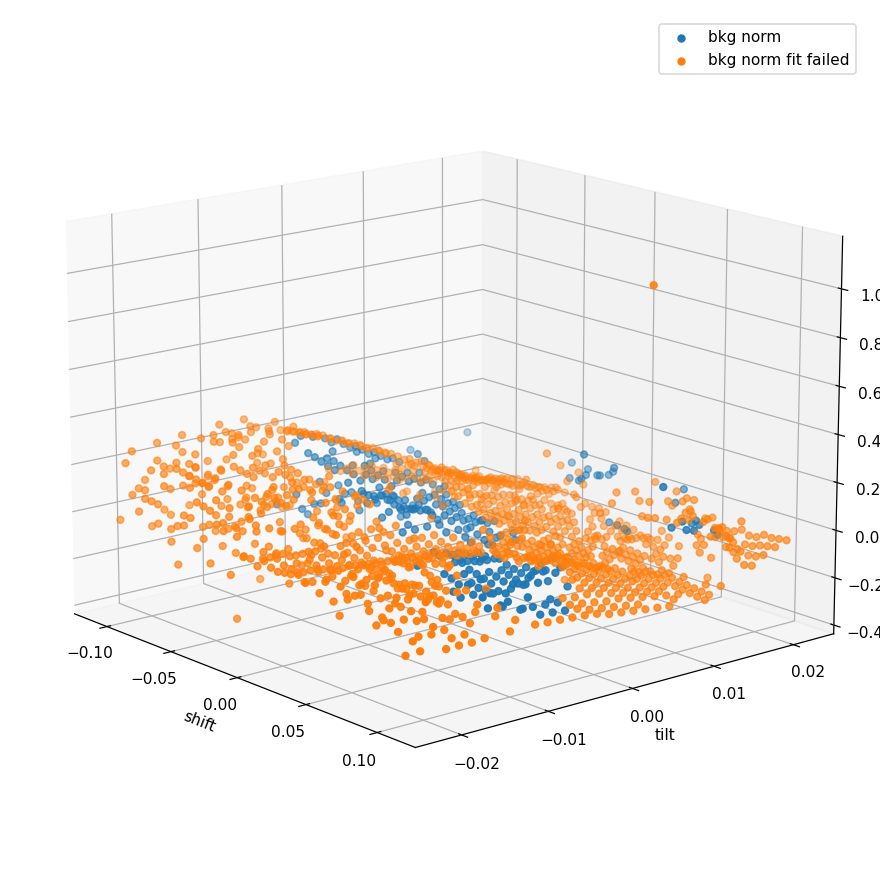

In [51]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

if bool(errors_norm_3d):#.size > 0:
    ax.scatter3D(*zip(*norm_3d), label='bkg norm') 
if bool(errors_norm_3d_fail):#.size > 0:
    ax.scatter3D(*zip(*norm_3d_fail), label='bkg norm fit failed', color='tab:orange') 
ax.view_init(15,320)
#ax.set_zlim3d(0.1565,0.1595)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('bkg norm')
ax.legend()
plt.tight_layout()
fig.savefig("plots/1b_tilt_shift_norm.pdf")
plt.show()

<IPython.core.display.Javascript object>


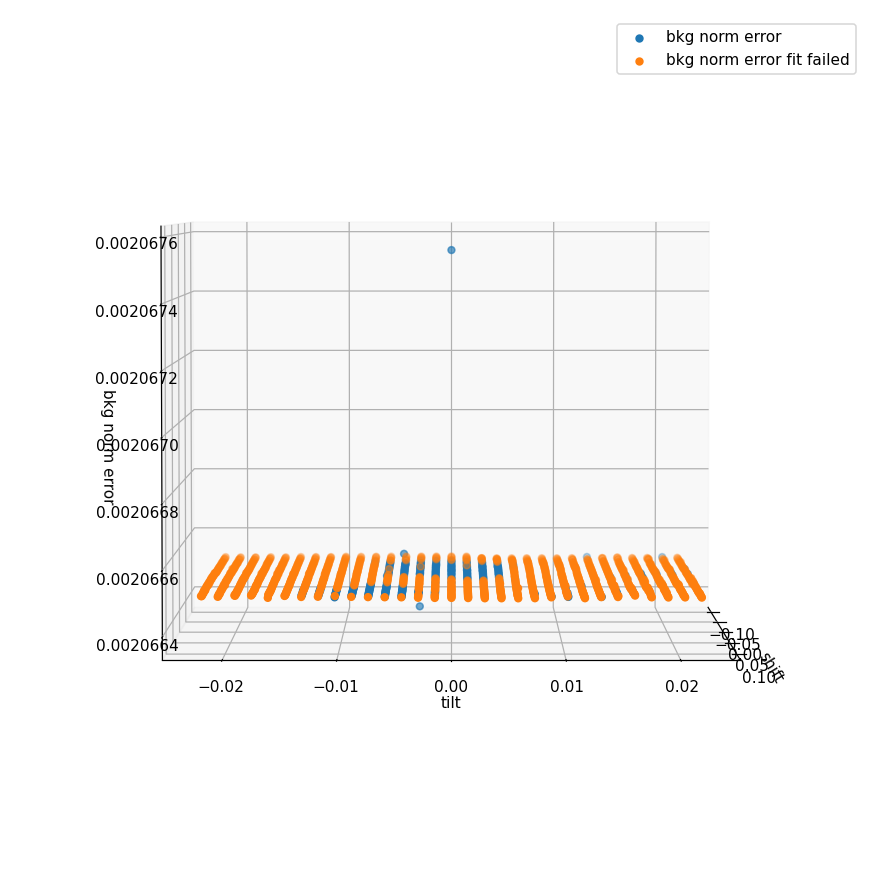

In [41]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

if bool(errors_norm_3d):#.size > 0:
    ax.scatter3D(*zip(*errors_norm_3d), label='bkg norm error') 
if bool(errors_norm_3d_fail):#.size > 0:
    ax.scatter3D(*zip(*errors_norm_3d_fail), label='bkg norm error fit failed', color='tab:orange')
ax.view_init(3,0)
#ax.set_zlim3d(0.0465,0.0490)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('bkg norm error')
ax.legend()
plt.tight_layout()
fig.savefig("plots/1b_tilt_shift_norm_error.pdf")
plt.show()